In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io
from tqdm import tqdm
import seaborn as sns
import cv2

In [12]:
# dataset path
c_root = '/home/hero/Data/heat_layout_data/200x200_0.045_0.055/complex_component/FDM/train/'
s_root = '/home/hero/Data/heat_layout_data/200x200_0.045_0.055/simple_component/FDM/train/'

cs9x5_resized_path = '/home/hero/Data/heat_layout_data/200x200_0.045_0.055/cs9x5_resized/train/'


In [60]:
mat1 = os.listdir(c_root)[0]
mat_file = io.loadmat(c_root + mat1)

In [23]:
class Resize:
    def __init__(self, size):
        self.size = size

    def __call__(self, x):
        return cv2.resize(x, self.size)

In [42]:
# mat load function
def mat_load(path,file):
    resize9x5 = Resize([128,64])
    mat_file = io.loadmat(path + file)
    return [resize9x5(mat_file['F']).astype('int16'), resize9x5(mat_file['u']).astype('int16')]

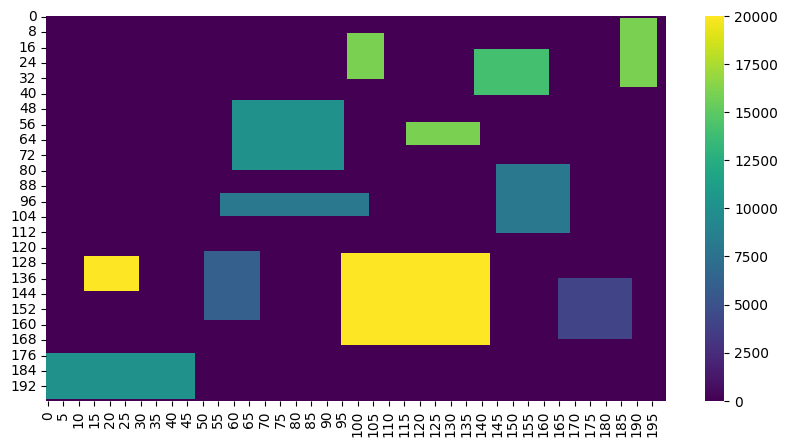

In [16]:
matrix = mat_file['F']
# 히트맵 그리기 함수
def plot_heatmap(matrix):
    # 히트맵 생성
    plt.figure(figsize=(10, 5))
    #ax = sns.heatmap(matrix, annot=True, fmt=".0f", cmap='viridis')
    ax = sns.heatmap(matrix, cmap='viridis')

    plt.show()
# 히트맵 그리기
plot_heatmap(matrix)

In [158]:
file_range = np.arange(0,10000)
c_idx_file = file_range // 27
c_idx_slice = file_range % 9
c_idx_p = file_range // 9
s_idx_file = file_range // 18
s_idx_slice = file_range % 9
s_idx_p = file_range // 9

In [178]:
i=0
print(file_range[c_idx_file==i])
print(c_idx_slice[c_idx_file==i])
print(c_idx_p[c_idx_file==i])
print(file_range[s_idx_file==i])
print(s_idx_slice[s_idx_file==i])
print(s_idx_p[s_idx_file==i]+3)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[0 1 2 3 4 5 6 7 8 0 1 2 3 4 5 6 7 8]
[3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4]


In [195]:
slices_c = c_idx_slice[c_idx_file==0]
ps_c = c_idx_p[c_idx_file==0]
slices_s = s_idx_slice[s_idx_file==0]
ps_s = s_idx_p[s_idx_file==0]+3

for i in tqdm(np.arange(0,300)):
    F = np.zeros([9,5,64,128])
    u = np.zeros([9,5,64,128])

    files_c = file_range[c_idx_file==i]
    files_s = file_range[s_idx_file==i]

    for idx,file in enumerate(files_c):
        filename_c = 'Example'+str(file+1)+'.mat'
        [arr_f,arr_u] = mat_load(c_root,filename_c)
        
        F[slices_c[idx],ps_c[idx],:,:] = arr_f
        u[slices_c[idx],ps_c[idx],:,:] = arr_u
    for idx,file in enumerate(files_s):
        filename_s = 'Example'+str(file+1)+'.mat'
        [arr_f,arr_u] = mat_load(s_root,filename_s)
        
        F[slices_s[idx],ps_s[idx],:,:] = arr_f
        u[slices_s[idx],ps_s[idx],:,:] = arr_u
    
    # save mat
    mat_file['F'] = F
    mat_file['u'] = u
    
    io.savemat(cs9x5_resized_path + 'Example' + str(i) + '.mat',mat_file)
        


100%|██████████| 300/300 [00:32<00:00,  9.25it/s]


In [194]:
type(u[0,0,0,0])

numpy.float64

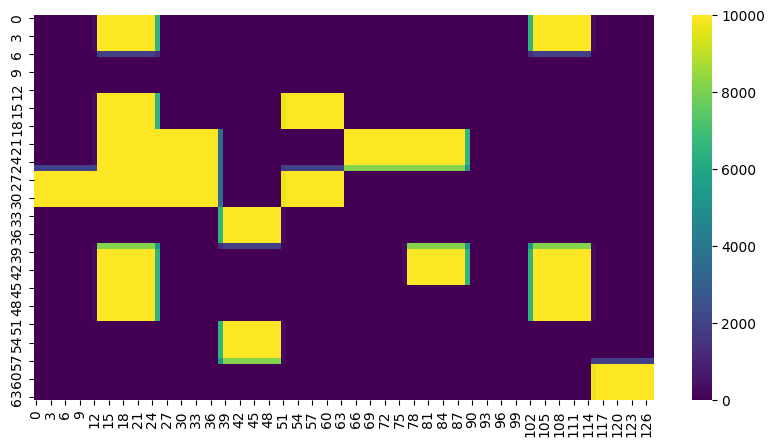

In [188]:
plot_heatmap(F[0,4,:,:])

In [90]:
np.any(u[0,1,:,:]==u[0,0,:,:])

True

In [7]:
geom = np.ones([16,32])
geom.shape

geom[5,20:23] = 0
geom[6,19:22] = 0
geom[7,18:21] = 0
geom[8,16:20] = 0
geom[9,17:19] = 0

geom[0,:] = 0
geom[-1,:] = 0

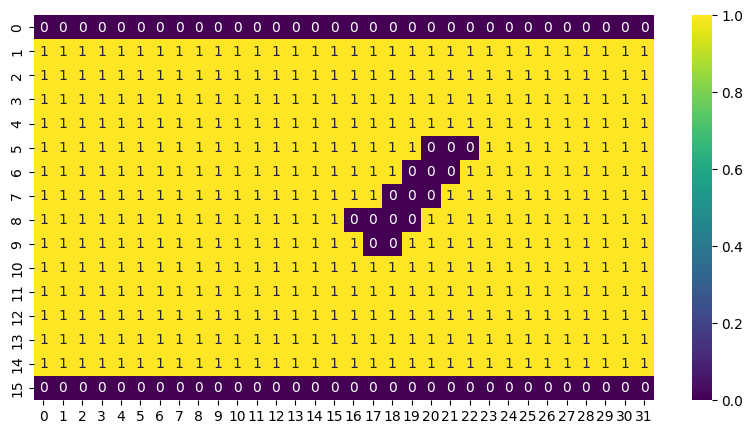

In [8]:
plot_heatmap(geom)

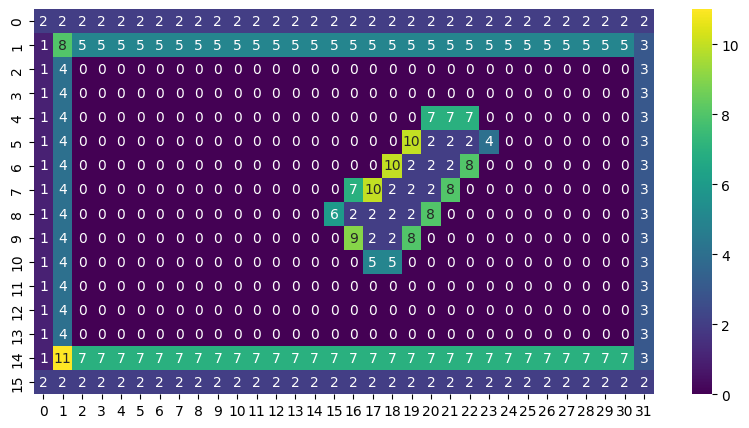

In [9]:
boundary = np.zeros_like(geom)
boundary[np.where(geom==0)] = 2
boundary[1:-1,0] = 1 # inlet
boundary[1:-1,-1] = 3 # outlet
boundary[1:-1,1] = 4
boundary[1,1:-1] = 5
boundary[-2,1:-1] = 7
boundary[1,1] = 8
boundary[-2,1] = 11

# near obstacle
boundary[4,20:23] = 7
boundary[5,19] = 10
boundary[5,23] = 4
boundary[6,18] = 10
boundary[6,22] = 8
boundary[7,16] = 7
boundary[7,17] = 10
boundary[7,21] = 8
boundary[8,15] = 6
boundary[8,20] = 8
boundary[9,16] = 9
boundary[9,19] = 8
boundary[10,17:19] = 5


plot_heatmap(boundary)

In [10]:
class Resize:
    def __init__(self, size):
        self.size = size

    def __call__(self, x):
        x_res = cv2.resize(x, self.size, interpolation=cv2.INTER_NEAREST)
        return x_res

In [11]:
import pandas as pd
import cv2
resize = Resize((256,128))
df_geom = pd.DataFrame(resize(geom)).astype('int')
df_geom.to_csv('df_geom.csv')

In [12]:
geom = pd.read_csv('df_geom_resized.csv',header=None).values.astype('int16')
boundary = pd.read_csv('df_boundary_resized.csv',header=None).values.astype('int16')

In [13]:
# save mat
mat_file['F'] = np.stack([geom,boundary])
mat_file['u'] = np.stack([boundary,boundary,boundary])

In [14]:
mat_file['F'].shape, mat_file['u'].shape

((2, 128, 256), (3, 128, 256))

In [15]:
for i in range(10000):
    io.savemat(nse_ref_geom_resized_path + '/train/' + 'nse_ref_' + str(i) + '.mat',mat_file)